In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [472]:
df = pd.read_csv(r'C:\Users\Germán\Github\Proyecto2\data\vehiculos-de-segunda-mano-sample.csv')

## Duplicados

In [473]:
#ver cantidad de duplicados 
df.duplicated().sum()


np.int64(237)

In [474]:
# Eliminamos duplicados 
df = df.drop_duplicates()

In [475]:
print(df.shape)

(99763, 28)


In [476]:
df.duplicated().sum()


np.int64(0)

In [477]:
#Mostrar nombres de cada columna en una lista
print(df.columns)


Index(['vehicle_type', 'make', 'model', 'version', 'fuel', 'year', 'kms',
       'power', 'doors', 'shift', 'color', 'photos', 'description', 'price',
       'currency', 'location', 'publish_date', 'update_date', 'dealer_name',
       'dealer_description', 'dealer_address', 'dealer_zip_code',
       'dealer_city', 'dealer_country_code', 'dealer_is_professional',
       'dealer_website', 'dealer_registered_at', 'date'],
      dtype='object')


Drop columns

In [478]:
df.duplicated().sum()


np.int64(0)

In [479]:
#Drop 'vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_address', 'dealer_zip_code','dealer_is_professional','dealer_city', 'dealer_country_code','dealer_website','dealer_registered_at', 'date'
df = df.drop(['dealer_name','vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_is_professional','dealer_city', 'dealer_country_code','dealer_website','dealer_registered_at',"date"], axis=1)

In [480]:
df.duplicated().sum()


np.int64(57058)

In [481]:
df.drop_duplicates(inplace=True)

In [482]:
df.duplicated().sum()

np.int64(0)

## Nulls

In [491]:
#Mostramos los nulos en porcetaje con relacion al total por cada fila 
df.isnull().sum()/df.shape[0]*100

make               0.0
model              0.0
version            0.0
fuel               0.0
year               0.0
kms                0.0
power              0.0
shift              0.0
price              0.0
location           0.0
publish_date       0.0
dealer_address     0.0
dealer_zip_code    0.0
dtype: float64

### Drop nulls from version and kms

In [484]:
#Drop nuls de "verion", kms, power,dealer_name
df = df.dropna(subset=['version', 'kms',"dealer_address"])

### Fixing Fuel, Power and Shift nulls

In [485]:
#Lista de variables a rellenar
variables = ['fuel', 'power', 'shift']
 
# Función para calcular la moda o mediana por modelo
def calculate_stat_by_model(df, var):
    if var == 'power':
        return df.groupby('model')[var].transform(lambda x: x.median() if not pd.isna(x.median()) else None)
    else:
        return df.groupby('model')[var].transform(lambda x: x.mode()[0] if not x.mode().empty else None)
 
# Función para rellenar los valores nulos
def fill_missing_values(df, var):
    stat_by_model = calculate_stat_by_model(df, var)
    df[var] = df[var].fillna(stat_by_model)
    return df
 
# Aplicar la función para cada variable
for var in variables:
    df = fill_missing_values(df, var)

c:\Users\Germán\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [486]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
 
# Mostrar el resultado completo para 'shift'
shift_nulls = df[df['shift'].isnull()][['make', 'model']].value_counts()
print("Shift Nulls:")
print(shift_nulls)

# Mostrar el resultado completo para 'power'
power_nulls = df[df['power'].isnull()][['make', 'model']].value_counts()
print("\nPower Nulls:")
print(power_nulls)

# Mostrar el resultado completo para 'fuel'
fuel_nulls = df[df['fuel'].isnull()][['make', 'model']].value_counts()
print("\nFuel Nulls:")
print(fuel_nulls)

Shift Nulls:
make   model 
Lotus  Esprit    1
Name: count, dtype: int64

Power Nulls:
make     model  
Citroen  ë-Jumpy    1
Name: count, dtype: int64

Fuel Nulls:
make     model    
Ferrari  LaFerrari    1
Lotus    Esprit       1
Tata     Indigo       1
Name: count, dtype: int64


In [487]:
#Rellenamos citroen e-jumpy con 100
df.loc[(df['make'] == 'Citroen') & (df['model'] == 'ë-Jumpy'), 'power'] = 100

In [488]:
#Rellenamos Lotus Esprit con manual
df.loc[(df['make'] == 'Lotus') & (df['model'] == 'Esprit'), 'shift'] = "manual"

In [489]:
modelos = "LaFerrari","Indigo","Esprit"
df.loc[df['model'].isin(modelos), 'fuel'] = 'Gasolina'

### Zip code

In [394]:
df['dealer_zip_code'] = df['dealer_zip_code'].astype(str)
 
df.loc[df['location'] == 'Parque Empresarial San Fernando de Henares', 'dealer_zip_code'] = df.loc[df['location'] == 'Parque Empresarial San Fernando de Henares', 'dealer_zip_code'].fillna('28830')
df.loc[df['location'] == 'Collado Villalba', 'dealer_zip_code'] = df.loc[df['location'] == 'Collado Villalba', 'dealer_zip_code'].fillna('28400')
df.loc[df['location'] == 'Elx/Elche', 'dealer_zip_code'] = df.loc[df['location'] == 'Elx/Elche', 'dealer_zip_code'].fillna('03203')

In [469]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [470]:
# Crear el geocodificador
geolocator = Nominatim(user_agent="my_app")
 
# Función para obtener la provincia a partir de una localización
def get_province(dealer_address):
    try:
        loc = geolocator.geocode(dealer_address, timeout=10)
        if loc:
            address = geolocator.reverse((loc.latitude, loc.longitude), timeout=10).raw['address']
            return address.get('state', 'Unknown')  # 'state' puede variar dependiendo del país
        else:
            return 'Unknown'
    except GeocoderTimedOut:
        return 'Unknown'
 
# Aplicar la función a la columna 'location' y crear una nueva columna 'province'
df['province'] = df['dealer_address'].apply(get_province)
 
# Mostrar el DataFrame resultante
print(df)

KeyboardInterrupt: 

In [321]:
#Mostramos la cantidad de filas donde dealer_zip_code es nulo
print(df['dealer_zip_code'].isnull().sum())

92


In [322]:
#Drop dealer_zip_code nulls
df = df.dropna(subset=['dealer_zip_code'])

In [323]:
# df[df['dealer_zip_code']=='Parque Empresarial San Fernando de Henares'].fillna('28830')
# df[df['dealer_zip_code']=='Collado Villalba'].fillna('28400')
# df[df['dealer_zip_code']=='Elx/Elche'].fillna('03203')

# Dtypes

In [492]:
df.dtypes

make                object
model               object
version             object
fuel                object
year                 int64
kms                float64
power              float64
shift               object
price                int64
location            object
publish_date        object
dealer_address      object
dealer_zip_code    float64
dtype: object

In [493]:
#Publish date to datetime
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [494]:
df.shape

(42355, 13)

In [495]:
#ver si tiene duplicados
df.duplicated().sum()

np.int64(0)

# Getting location latitud and longitude

### Reading latitud and longitude excel

In [496]:
# pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [497]:
# Ruta del archivo Excel
ruta_excel = r"C:\Users\Germán\Github\Proyecto2\data\listado-longitud-latitud-municipios-espana.xls"  
ruta_csv = r"C:\Users\Germán\Github\Proyecto2\data\municipios.csv"    

# Leer el archivo Excel
datos = pd.read_excel(ruta_excel)

# Guardar como CSV
datos.to_csv(ruta_csv, index=False)

print(f"Archivo convertido y guardado como {ruta_csv}")


Archivo convertido y guardado como C:\Users\Germán\Github\Proyecto2\data\municipios.csv


In [498]:
#Eliminar la primera filas
datos = datos.drop(0)

In [499]:
#Hacemos que la primera fila sea el header
datos.columns = datos.iloc[0]

#Eliminamos la primera fila
datos = datos.drop(1)

In [500]:
#Quitamos acentos en el header
datos.columns = datos.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

#Quitamo mayusculas en el header
datos.columns = datos.columns.str.lower()

In [501]:
datos.head(1)

1,comunidad,provincia,poblacion,latitud,longitud,altitud,habitantes,hombres,mujeres
2,Andalucía,Almería,Abla,37.14114,-2.780104,871.1684,1504,783,721


### Merge both csv

In [502]:
# Asegúrate de que las columnas tengan el mismo nombre para el merge
datos.rename(columns={'poblacion': 'location'}, inplace=True)

# Realizar el merge
df_final = pd.merge(df, datos[['location', 'latitud', 'longitud']], on='location', how='left')


In [503]:
df_final.head(1)

,make,model,version,fuel,year,kms,power,shift,price,location,publish_date,dealer_address,dealer_zip_code,latitud,longitud
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Pineda de Mar,2023-02-04,"2, Carrer de Jacint Benavente, Poblenou, Pineda de Mar, Maresme, Barcelona, Catalunya, 08397, España",8397.0,41.62751,2.689454


In [507]:
df_final.shape

(42404, 15)

In [508]:
df.shape

(42355, 13)

In [506]:
df_final.isnull().sum()/df.shape[0]*100

make                0.000000
model               0.000000
version             0.000000
fuel                0.000000
year                0.000000
kms                 0.000000
power               0.000000
shift               0.000000
price               0.000000
location            0.000000
publish_date        0.000000
dealer_address      0.000000
dealer_zip_code     0.000000
latitud            20.963287
longitud           20.963287
dtype: float64

# EDA

### Kms

In [511]:
#Generar una columna nueva diviendo los datos segun la cantidad de kms en 3 categorias
df['kms_category'] = pd.cut(df['kms'], bins=[0, 50000, 100000, 150000, float("inf")], labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

#Mostrar la cantidad de autos por cada categoria
print(df['kms_category'].value_counts())

kms_category
Medio       15327
Bajo        12272
Alto        10066
Muy Alto     4650
Name: count, dtype: int64


C:\Users\Germán\AppData\Local\Temp\ipykernel_28412\2805510823.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='kms_category', palette='viridis')


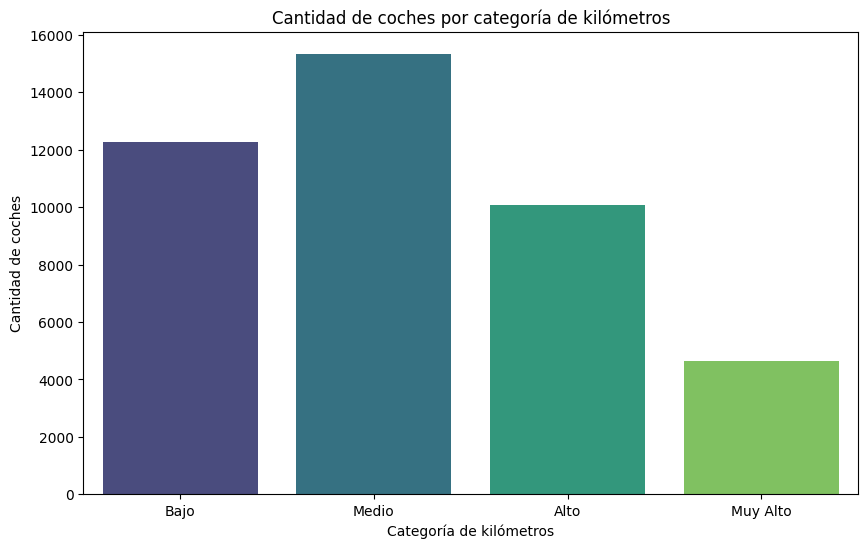

In [513]:
#Gráfico de barras de la cantidad de coches por cada categoria
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='kms_category', palette='viridis')
plt.title('Cantidad de coches por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Cantidad de coches')
plt.show()

C:\Users\Germán\AppData\Local\Temp\ipykernel_28412\2909093658.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='kms_category', y='price',palette='viridis')


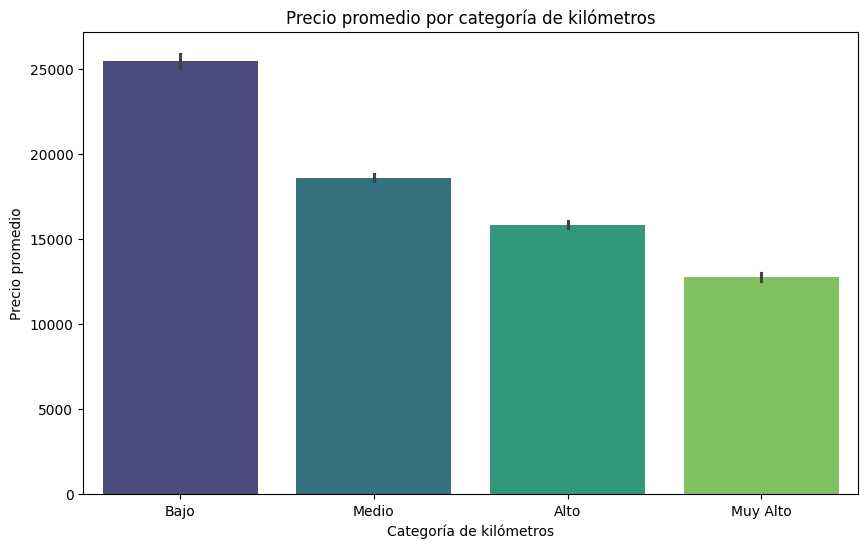

In [514]:
#Precio promedio segun categoria de kms.
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='kms_category', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Fuel Type

C:\Users\Germán\AppData\Local\Temp\ipykernel_28412\392846457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='fuel', y='price',palette='viridis')


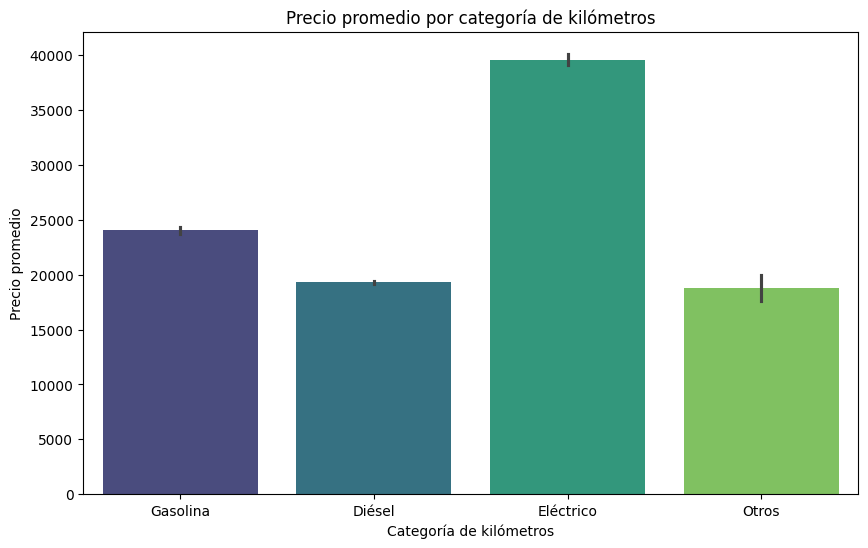

In [ ]:
#Precio promedio segun categoria de kms.
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='fuel', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Shift Type

C:\Users\Germán\AppData\Local\Temp\ipykernel_28412\2519147538.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='shift', y='price',palette='viridis')


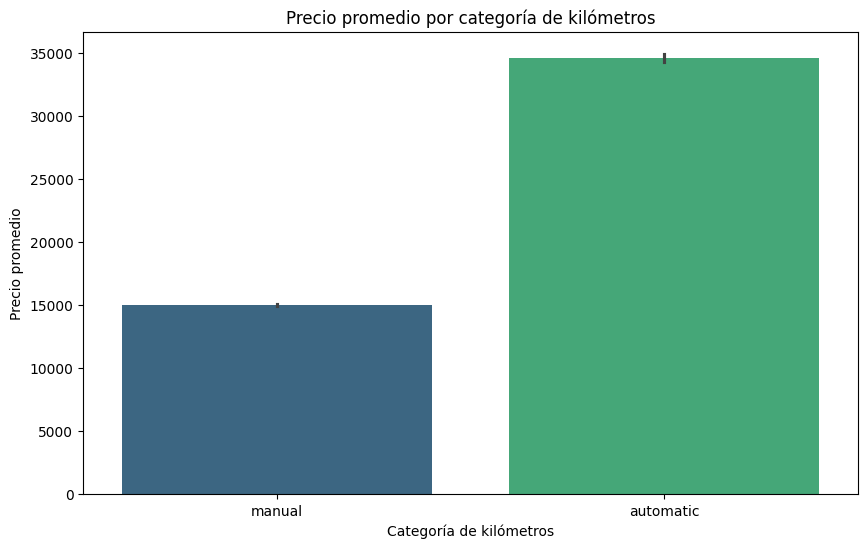

In [51]:
#Precio promedio segun categoria de kms. grafica
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='shift', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Year

C:\Users\Germán\AppData\Local\Temp\ipykernel_28412\1751108334.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='year', y='price', palette='viridis')


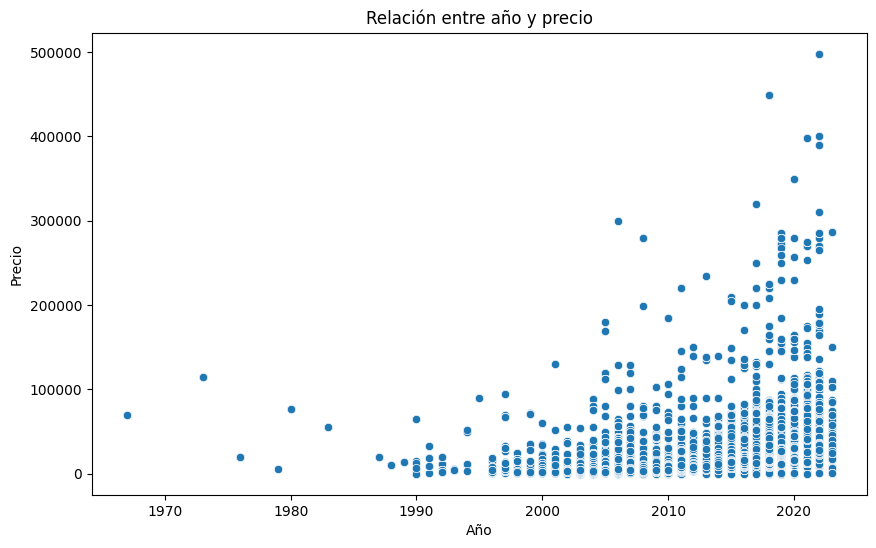

In [48]:
#Relacion entre year y precio 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='price', palette='viridis')
plt.title('Relación entre año y precio')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.show()

Haria lo mismo segun la provincia si logramos sacarlas para ver si en general los precios de x provincias suelen ser mas altos o mas bajos